In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import sinkhorn as skh
import oracles as oracle
import model as md
import time
import pickle

In [2]:
np.version.version

'1.18.2'

In [3]:
net_name = 'data/EMA_net.tntp'
trips_name = 'data/EMA_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 3, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

In [4]:
df = graph_data['graph_table']
df[df['Init node'] == 1].head()

,Init node,Term node,Capacity,length,Free Flow Time
0,1,3,4938.061523,16.106817,0.238965
2,1,7,7309.824707,16.058741,0.222813
4,1,9,1164.374878,17.455400,0.402046


In [5]:
correspondence_matrix = handler.from_dict_to_cor_matr(graph_correspondences, n)
T = handler.create_C(df, n, column_name='Free Flow Time')
# C = handler.create_C(df, n, column_name='length')
np.savetxt('data/T.csv', T, delimiter=',')

L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)

people_num = np.nansum(L)

L = handler.distributor_L_W(L)
W = handler.distributor_L_W(W)

L = L / np.nansum(L)
W = W / np.nansum(W)

print('people_num: ', people_num)

people_num:  65576.37543100001


In [6]:
T[0][6]

0.22281299531459808

In [7]:
T

array([[     nan,      nan, 0.238965, ...,      nan,      nan,      nan],
       [     nan,      nan, 0.106992, ...,      nan,      nan,      nan],
       [0.240297, 0.108032,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])

##### Подумаем над T, это должны быть кратчайшие пути, а не полупустая таблица с путями из i в j как у нас
В данных по Москве время в минутах. В этих данных время по часам! ('Time: hours, distance: miles'). Поэтому альфа получается таким большим, оно масштабирует. В Москве время было в минутах. Также в T много нулей, поэтому там, где стоят nan, поставим по 100 часов, типа много затрат и поэтому никто так не ездит (сделано там, где инициализируется cost_matrix)

In [8]:
def get_T_from_shortest_distances(n, graph_data):
    targets = []
    T = None
    i = 0
    for source in range(n):
        targets = [source]
        targets += range(0, n)
        
        graph = tg.TransportGraph(graph_data)

        t_exp = np.array(df['Free Flow Time'], dtype = 'float64').flatten()
        
        distances, pred_map = graph.shortest_distances(source = source,
                                            targets = targets,
                                            times = t_exp)
        
        if i == 0:
            T = distances[1:]
        else:
            T = np.vstack([T, distances[1:]])
        targets = []
        i += 1
    
    return T

In [9]:
array = [1, 2, 3, 4]
array[1:]

[2, 3, 4]

In [10]:
import transport_graph as tg


T = get_T_from_shortest_distances(n, graph_data)

##### Запускаем Синхорна для поиска лучшего alpha

In [11]:
num_iter = 2500
alpha, beta = 1.0, 1.0
alpha_range  = np.arange(0.0, 10.0, 0.25)

best_matrix = None
min_reconstruction_error = np.inf
best_alpha, best_beta = np.nan, np.nan
eps = 10**(-3)

s = skh.Sinkhorn(n, L, W, people_num, num_iter, eps)

er_list = []

lambda_L = np.full((n, ), 0.0, dtype=np.double)
lambda_W = np.full((n, ), 0.0, dtype=np.double)

for alpha_idx in range(len(alpha_range)):
    alpha = alpha_range[alpha_idx]
    cost_matrix = np.nan_to_num(T * alpha, nan=100)
    rec, _, _ = s.iterate(cost_matrix, lambda_L, lambda_W)
        
    er = np.linalg.norm(rec - np.nan_to_num(correspondence_matrix, nan=0.0))
    er = np.sqrt( er / np.sum(np.nan_to_num(correspondence_matrix, nan=0.0)) )
    er_list.append(er)

    if er < min_reconstruction_error:
        min_reconstruction_error = er
        best_alpha  = alpha_range[alpha_idx]
        best_matrix = rec

In [12]:
best_matrix

array([[261.94248159, 114.26108967, 150.91339746, ...,   0.01055395,
          0.00962036,   0.00946793],
       [ 62.71660536, 155.19810926, 119.7447598 , ...,   0.00837421,
          0.00729554,   0.00717994],
       [ 15.25044967,  22.04586726,  29.11767022, ...,   0.00203631,
          0.00177402,   0.00174591],
       ...,
       [  0.00682422,   0.00986501,   0.01302948, ...,   0.00005857,
          0.00000684,   0.00001136],
       [  0.00422504,   0.00568114,   0.00750351, ...,   0.00000435,
          0.00043081,   0.00003535],
       [  0.00410757,   0.00552319,   0.0072949 , ...,   0.00000714,
          0.00003493,   0.00005802]])

In [13]:
correspondence_matrix

array([[       nan,  63.802849, 471.81948 , ...,        nan,        nan,
               nan],
       [ 44.610847,        nan, 118.65221 , ...,        nan,        nan,
               nan],
       [ 67.639683,  72.07049 ,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [14]:
min_reconstruction_error

0.24273090555473334

In [15]:
er_list[0] - min_reconstruction_error

0.005565789227545748

In [16]:
best_alpha # 2.54020000000114

2.5

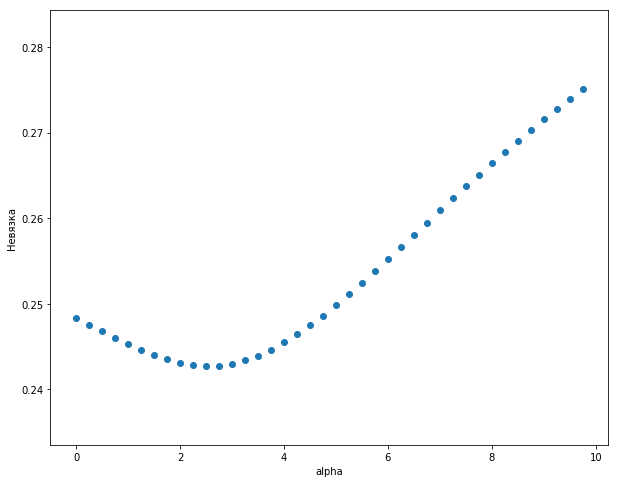

In [17]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(alpha_range, er_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()

##### Multi-stage

In [11]:
t_1 = time.time()
for i in range(1000):
    x = i**(i+1)
t_2 = time.time()
print('Elapsed time: {:.0f} sec'.format(t_2 - t_1), t_2-t_1)

Elapsed time: 0 sec 0.009868860244750977


In [18]:
best_correcpondences_dict = handler.from_cor_matrix_to_dict(best_matrix)
model = md.Model(graph_data, best_correcpondences_dict, 
                 total_od_flow, mu = 0.25, rho = 0.15)

max_iter = 5000

for i, eps_abs in enumerate(np.logspace(1,3,1)):
    
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'multi-stage', 
                                    solver_kwargs = solver_kwargs, 
                                    verbose = False)

eps_abs = 10.0
multi-stage model....


/usr/local/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pred_edges' of function 'get_flows'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "oracles.py", line 26:
@njit
def get_flows(nodes_number, edges_number, targets, target_flows, pred_arr, pred_edges, sorted_vertices):  
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_vertices' of function 'get_flows'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "oracles.py"

t: 0.8772975933658534
flows: 45948.48873711
rec: 2244.6831456575674
t: 0.8771654430237612
flows: 2316.3911562813787
rec: 274.4454405917412
t: 0.8770341492268731
flows: 2316.3911562813787
rec: 274.3775375734871
t: 0.8769035157189766
flows: 2316.3911562813782
rec: 274.3120679383241
t: 0.8767734267430412
flows: 2316.3911562813787
rec: 274.24820242178527
t: 0.8766438045775212
flows: 2316.3911562813787
rec: 274.18556156078563
t: 0.8765146078678903
flows: 2316.391156281379
rec: 274.12392324231473
t: 0.8763857794229835
flows: 2315.0374834350773
rec: 274.0631450365492
t: 0.8762572856788484
flows: 2314.03750141524
rec: 274.00316153795154
t: 0.8761290993330871
flows: 2313.2688002543173
rec: 273.94384573531596
t: 0.8760011977733723
flows: 2312.659554647191
rec: 273.88513422162924
t: 0.875873561853116
flows: 2312.164862751337
rec: 273.8269756940788
t: 0.8757461751652116
flows: 2311.7552211815514
rec: 273.76932763280735
t: 0.8756190234649038
flows: 2311.4104497339886
rec: 273.71215458847627
t: 0.87

t: 0.8630893506784053
flows: 2303.365893512683
rec: 268.86809707191117
t: 0.8629709585731111
flows: 2303.314439794846
rec: 268.8267729113234
t: 0.8628526103036331
flows: 2303.2638989120005
rec: 268.785523411063
t: 0.862734305580685
flows: 2303.2142468357133
rec: 268.7443480521926
t: 0.8626160441192139
flows: 2303.16546037199
rec: 268.70324632357045
t: 0.862497825638305
flows: 2303.1175171254213
rec: 268.66221772166665
t: 0.8623796498610876
flows: 2303.07039546517
rec: 268.6212617503899
t: 0.8622615165146444
flows: 2303.0240744926673
rec: 268.580377920917
t: 0.8621434253299246
flows: 2302.978534010939
rec: 268.5395657515274
t: 0.8620253760416582
flows: 2302.9337544954506
rec: 268.4988247674451
t: 0.8619073683882738
flows: 2302.889717066404
rec: 268.4581545006822
t: 0.8617894021118181
flows: 2302.8464034623794
rec: 268.4175544898899
t: 0.8616714769578787
flows: 2302.80379601526
rec: 268.3770242802125
t: 0.8615535926755082
flows: 2302.7618776263726
rec: 268.3365634231458
t: 0.861435749017

t: 0.8495953049822156
flows: 2300.4262321867095
rec: 264.4781993602255
t: 0.849480730139339
flows: 2300.413924641112
rec: 264.4432829000154
t: 0.8493661807590334
flows: 2300.40172489902
rec: 264.40840857268773
t: 0.8492516567542067
flows: 2300.389631551069
rec: 264.37357622639803
t: 0.8491371580384183
flows: 2300.3776432123454
rec: 264.33878571046426
t: 0.8490226845258713
flows: 2300.3657585218507
rec: 264.3040368753511
t: 0.8489082361314049
flows: 2300.3539761419947
rec: 264.2693295726576
t: 0.8487938127704869
flows: 2300.342294758089
rec: 264.23466365510427
t: 0.8486794143592074
flows: 2300.330713077862
rec: 264.20003897651975
t: 0.8485650408142701
flows: 2300.3192298309837
rec: 264.1654553918268
t: 0.848450692052987
flows: 2300.3078437686
rec: 264.1309127570318
t: 0.8483363679932703
flows: 2300.296553662885
rec: 264.09641092921066
t: 0.848222068553626
flows: 2300.2853583065944
rec: 264.0619497664966
t: 0.8481077936531477
flows: 2300.2742565126428
rec: 264.02752912806966
t: 0.8479935

t: 0.8364537455640902
flows: 2299.7285001326627
rec: 260.67459536365806
t: 0.8363415213235631
flows: 2299.7393210167193
rec: 260.6436017720754
t: 0.8362293154973174
flows: 2299.7501146645122
rec: 260.6126382181596
t: 0.8361171280424009
flows: 2299.760881013487
rec: 260.58170462790474
t: 0.8360049589160782
flows: 2299.7716200051527
rec: 260.55080092768856
t: 0.8358928080758281
flows: 2299.7823315849705
rec: 260.51992704426976
t: 0.8357806754793432
flows: 2299.7930157022597
rec: 260.4890829047839
t: 0.8356685610845275
flows: 2299.8036723100913
rec: 260.45826843674166
t: 0.8355564648494946
flows: 2299.814301365196
rec: 260.4274835680243
t: 0.8354443867325667
flows: 2299.8249028278633
rec: 260.3967282268828
t: 0.8353323266922724
flows: 2299.8354766618545
rec: 260.366002341933
t: 0.8352202846873457
flows: 2299.8460228343115
rec: 260.3353058421539
t: 0.8351082606767236
flows: 2299.8565413156616
rec: 260.3046386568847
t: 0.8349962546195456
flows: 2299.867032079544
rec: 260.27400071582156
t: 0

t: 0.8235494681444414
flows: 2301.900763153703
rec: 257.2626312070079
t: 0.8234391488545947
flows: 2301.930635705384
rec: 257.23469291609246
t: 0.8233288441102005
flows: 2301.9603952586467
rec: 257.20677802165034
t: 0.8232185538854204
flows: 2301.9900424413063
rec: 257.178886479826
t: 0.823108278154515
flows: 2302.0195778766542
rec: 257.1510182469336
t: 0.8229980168918423
flows: 2302.0490021834953
rec: 257.1231732794598
t: 0.8228877700718575
flows: 2302.07831597619
rec: 257.09535153405966
t: 0.8227775376691127
flows: 2302.1075198646877
rec: 257.06755296755694
t: 0.8226673196582556
flows: 2302.136614454569
rec: 257.03977753694284
t: 0.8225571160140298
flows: 2302.1656003470844
rec: 257.0120251993751
t: 0.8224469267112737
flows: 2302.194478139186
rec: 256.9842959121774
t: 0.8223367517249197
flows: 2302.2232484235697
rec: 256.95658963283745
t: 0.822226591029995
flows: 2302.2519117887095
rec: 256.9289063190061
t: 0.8221164446016189
flows: 2302.280468818896
rec: 256.90124592849776
t: 0.8220

t: 0.8108388608777157
flows: 2304.301269455164
rec: 254.16151495454122
t: 0.8107299676253287
flows: 2304.3117384273387
rec: 254.1358793070484
t: 0.8106210864865225
flows: 2304.32220349722
rec: 254.11026296566143
t: 0.810512217443843
flows: 2304.3326645196944
rec: 254.08466590102861
t: 0.8104033604798896
flows: 2304.343121351771
rec: 254.0590880838863
t: 0.8102945155773152
flows: 2304.3535738525584
rec: 254.0335294850621
t: 0.8101856827188256
flows: 2304.3640218832343
rec: 254.00799007547198
t: 0.8100768618871792
flows: 2304.37446530702
rec: 253.98246982612224
t: 0.8099680530651874
flows: 2304.384903989152
rec: 253.95696870810704
t: 0.8098592562357133
flows: 2304.3953377968564
rec: 253.93148669260967
t: 0.8097504713816724
flows: 2304.4057665993228
rec: 253.90602375090126
t: 0.8096416984860321
flows: 2304.416190267682
rec: 253.88057985434122
t: 0.8095329375318109
flows: 2304.426608674975
rec: 253.85515497437603
t: 0.809424188502079
flows: 2304.4370216961297
rec: 253.8297490825401
t: 0.80

t: 0.798270325652811
flows: 2261.9394327905657
rec: 251.32203707108857
t: 0.7981623758276833
flows: 2260.8047101216525
rec: 251.29881075874948
t: 0.7980544015635541
flows: 2259.6732686541545
rec: 251.27559992251585
t: 0.7979464377637097
flows: 2258.476667241421
rec: 251.25240250180934
t: 0.7978384844152495
flows: 2257.283592922645
rec: 251.2290366180045
t: 0.797730541505312
flows: 2256.094030311468
rec: 251.20568702452434
t: 0.7976226090210735
flows: 2254.907964110239
rec: 251.1823536989471
t: 0.7975146869497481
flows: 2253.725379109375
rec: 251.1590366188838
t: 0.7974067752785869
flows: 2252.546260186733
rec: 251.13573576197078
t: 0.7972988739948776
flows: 2251.3705923069824
rec: 251.11245110586555
t: 0.7971909830859436
flows: 2250.198360520989
rec: 251.0891826282426
t: 0.7970831025391444
flows: 2249.0295499652007
rec: 251.06593030678945
t: 0.796975232341874
flows: 2247.8641458610336
rec: 251.04269411920544
t: 0.7968673724815617
flows: 2246.702133514277
rec: 251.01947404319836
t: 0.79

t: 0.7841026385387687
flows: 2129.8818001584896
rec: 248.4082377277796
t: 0.7838892520375149
flows: 2128.197123373176
rec: 248.36533013924125
t: 0.783675901573474
flows: 2126.5208170158226
rec: 248.3224774859431
t: 0.7834625870719106
flows: 2124.8528195302647
rec: 248.2796796351836
t: 0.7832493084584166
flows: 2123.1930699581576
rec: 248.2369364548644
t: 0.7830360656589082
flows: 2121.5415079317695
rec: 248.19424781350514
t: 0.7828228585996251
flows: 2119.898073666875
rec: 248.15161358025335
t: 0.7826096872071266
flows: 2118.262707955763
rec: 248.10903362489069
t: 0.7823965514082907
flows: 2116.63535216033
rec: 248.06650781783617
t: 0.7821834511303118
flows: 2115.0159482052845
rec: 248.0240360301489
t: 0.7819703863006978
flows: 2113.4044385714355
rec: 247.98161813352667
t: 0.7817573568472691
flows: 2111.8007662890905
rec: 247.9392540003063
t: 0.7815443626981555
flows: 2110.204874931537
rec: 247.89694350346045
t: 0.7813314037817948
flows: 2108.616708608615
rec: 247.8546865165956
t: 0.78

t: 0.759569096873841
flows: 1957.9821840266447
rec: 243.67540145786484
t: 0.7593593942061315
flows: 1956.6347680901906
rec: 243.63637100148463
t: 0.7591497208064141
flows: 1955.2926508218804
rec: 243.59738447797696
t: 0.758940076626534
flows: 1953.9558015527316
rec: 243.55844180428525
t: 0.7587304616185021
flows: 1952.6241898475234
rec: 243.51954289767428
t: 0.758520875734494
flows: 1951.297785502585
rec: 243.48068767572718
t: 0.7583113189268491
flows: 1949.9765585436169
rec: 243.44187605634605
t: 0.7581017911480697
flows: 1948.66047922353
rec: 243.40310795774758
t: 0.7578922923508203
flows: 1947.3495180203086
rec: 243.36438329846268
t: 0.7576828224879266
flows: 1946.043645634905
rec: 243.32570199733337
t: 0.7574733815123748
flows: 1944.7428329891457
rec: 243.28706397351195
t: 0.7572639693773103
flows: 1943.4470512236717
rec: 243.24846914645798
t: 0.7570545860360379
flows: 1942.1562716958965
rec: 243.20991743593785
t: 0.7568452314420199
flows: 1940.8704659779871
rec: 243.1714087620217


t: 0.7356370143439306
flows: 1834.5973646970367
rec: 239.42103487458033
t: 0.7354303850733499
flows: 1833.733007174381
rec: 239.3861604070727
t: 0.7352237804899602
flows: 1832.871529214443
rec: 239.35132228998987
t: 0.7350172005600414
flows: 1832.0129168127494
rec: 239.3165204667725
t: 0.7348106452499696
flows: 1831.1571560539828
rec: 239.2817548810353
t: 0.7346041145262164
flows: 1830.304233111286
rec: 239.24702547656688
t: 0.7343976083553483
flows: 1829.4541342455664
rec: 239.21233219732727
t: 0.7341911267040259
flows: 1828.606845804806
rec: 239.17767498744874
t: 0.7339846695390044
flows: 1827.7623542233857
rec: 239.14305379123385
t: 0.7337782368271327
flows: 1826.9206460214048
rec: 239.10846855315464
t: 0.7335718285353526
flows: 1826.0817078040159
rec: 239.0739192178531
t: 0.7333654446306995
flows: 1825.2455262607639
rec: 239.03940573013895
t: 0.7331590850803009
flows: 1824.4120881649253
rec: 239.00492803498886
t: 0.7329527498513762
flows: 1823.5813803728597
rec: 238.97048607754684


t: 0.7120309784399439
flows: 1750.545997157153
rec: 235.6235823747828
t: 0.7118270122572882
flows: 1749.933245729504
rec: 235.59240515987906
t: 0.7116231323406084
flows: 1749.3222258155492
rec: 235.5612584543433
t: 0.7114192737462129
flows: 1748.7159740128668
rec: 235.53014596122003
t: 0.7112154364492087
flows: 1748.1114376557618
rec: 235.49906249675385
t: 0.7110116204247633
flows: 1747.5086096449606
rec: 235.46800931654883
t: 0.7108078256481055
flows: 1746.9074829196722
rec: 235.43698638012387
t: 0.7106040520945244
flows: 1746.3080504573309
rec: 235.40599364710155
t: 0.7104002997393698
flows: 1745.710305273339
rec: 235.37503107720707
t: 0.7101965685580515
flows: 1745.1142404208167
rec: 235.3440986302676
t: 0.7099928585260391
flows: 1744.5198489903491
rec: 235.31319626621195
t: 0.7097891696188614
flows: 1743.9271241097347
rec: 235.28232394507077
t: 0.709585501812107
flows: 1743.3360589437407
rec: 235.25148162697525
t: 0.7093818550814232
flows: 1742.7466466938588
rec: 235.220669272157
t

t: 0.688516874325141
flows: 1690.074422452625
rec: 232.20080429659444
t: 0.6883154138920137
flows: 1689.6348712801878
rec: 232.17304347961078
t: 0.6881139722726796
flows: 1689.1964322993713
rec: 232.14530868965582
t: 0.6879125494479433
flows: 1688.7591014212499
rec: 232.1175998954607
t: 0.6877111453986507
flows: 1688.3228745764939
rec: 232.08991706583018
t: 0.687509760105689
flows: 1687.8877477152532
rec: 232.06226016964075
t: 0.6873083935499863
flows: 1687.4537168070447
rec: 232.03462917584156
t: 0.6871070457125112
flows: 1687.0207778406402
rec: 232.0070240534544
t: 0.6869057165742734
flows: 1686.5889268239478
rec: 231.97944477157264
t: 0.6867044061163226
flows: 1686.158159783903
rec: 231.95189129936014
t: 0.6865031143197491
flows: 1685.7284727663598
rec: 231.92436360605294
t: 0.6863018411656832
flows: 1685.2998618359743
rec: 231.89686166095748
t: 0.6861005866352952
flows: 1684.8723230760982
rec: 231.86938543345127
t: 0.6858993507097952
flows: 1684.4458525886703
rec: 231.8419348929808

t: 0.6654660398251833
flows: 1646.1352017269312
rec: 229.16734262101332
t: 0.6652665871529425
flows: 1645.8057491953218
rec: 229.14228372187227
t: 0.6650671513319194
flows: 1645.4770429914524
rec: 229.11724768575664
t: 0.6648677323468609
flows: 1645.1490806622078
rec: 229.09223448817855
t: 0.6646683301825429
flows: 1644.8218597649757
rec: 229.06724410469653
t: 0.6644689448237697
flows: 1644.4953778675851
rec: 229.04227651091645
t: 0.6642695762553745
flows: 1644.1696325482515
rec: 229.01733168249115
t: 0.664070224462219
flows: 1643.8446213955237
rec: 228.9924095951193
t: 0.6638708894291927
flows: 1643.5203420082298
rec: 228.9675102245467
t: 0.6636715711412142
flows: 1643.1967919954232
rec: 228.94263354656468
t: 0.6634722695832299
flows: 1642.8739689763272
rec: 228.91777953701143
t: 0.6632729847402146
flows: 1642.5518705802854
rec: 228.89294817177068
t: 0.6630737165971707
flows: 1642.2304944467066
rec: 228.86813942677202
t: 0.6628744651391294
flows: 1641.9098382250122
rec: 228.8433532779

t: 0.6425957092687855
flows: 1581.3546868514454
rec: 226.471632523039
t: 0.642396975759
flows: 1579.6276946281553
rec: 226.45189848159464
t: 0.642198257649648
flows: 1577.9038611843775
rec: 226.4321816954563
t: 0.6419995549271339
flows: 1576.1831779939605
rec: 226.4124821558462
t: 0.6418008675778908
flows: 1574.4656365615067
rec: 226.39279985389817
t: 0.64160219558838
flows: 1572.7512284222323
rec: 226.373134780659
t: 0.6414035389450905
flows: 1571.039945141832
rec: 226.3534869270901
t: 0.6412048976345394
flows: 1569.3317783163368
rec: 226.33385628406867
t: 0.6410062716432718
flows: 1567.6267195719847
rec: 226.3142428423902
t: 0.6408076609578605
flows: 1565.9247605650776
rec: 226.29464659276954
t: 0.6406090655649054
flows: 1564.2258929818533
rec: 226.27506752584173
t: 0.6404104854510341
flows: 1562.5301085383487
rec: 226.25550563216447
t: 0.640211920602902
flows: 1560.8373989802649
rec: 226.23596090221918
t: 0.6400133710071911
flows: 1559.1477560828375
rec: 226.21643332641253
t: 0.6398

t: 0.6196420402125072
flows: 1400.1261076205396
rec: 224.29491359789546
t: 0.6194450082361652
flows: 1398.7154918748186
rec: 224.27710861121264
t: 0.6192479902465673
flows: 1397.3072207193732
rec: 224.25931955151123
t: 0.6190509862327747
flows: 1395.901288432026
rec: 224.24154640629538
t: 0.618853996183868
flows: 1394.4976893092908
rec: 224.2237891630684
t: 0.6186570200889464
flows: 1393.0964176662956
rec: 224.2060478093329
t: 0.6184600579371274
flows: 1391.6974678367073
rec: 224.1883223325913
t: 0.6182631097175473
flows: 1390.300834172657
rec: 224.17061272034582
t: 0.6180661754193606
flows: 1388.9065110446602
rec: 224.15291896009947
t: 0.6178692550317407
flows: 1387.5144928415489
rec: 224.1352410393546
t: 0.6176723485438793
flows: 1386.124773970392
rec: 224.11757894561535
t: 0.6174754559449862
flows: 1384.7373488564258
rec: 224.09993266638617
t: 0.6172785772242897
flows: 1383.3522119429758
rec: 224.08230218917276
t: 0.6170817123710363
flows: 1381.969357691387
rec: 224.0646875014822
t:

t: 0.5970731523728986
flows: 1251.7010262539543
rec: 222.35459327590885
t: 0.5968776712180691
flows: 1250.5226903449698
rec: 222.3386237145079
t: 0.5966822029021446
flows: 1249.3461485450973
rec: 222.32266866177196
t: 0.5964867474160339
flows: 1248.1713968556126
rec: 222.30672810602553
t: 0.5962913047506595
flows: 1246.998431289732
rec: 222.29080203560315
t: 0.5960958748969577
flows: 1245.8272478725771
rec: 222.274890438853
t: 0.5959004578458783
flows: 1244.6578426411213
rec: 222.25899330413353
t: 0.595705053588385
flows: 1243.4902116441501
rec: 222.24311061981476
t: 0.5955096621154551
flows: 1242.3243509422184
rec: 222.22724237427906
t: 0.5953142834180795
flows: 1241.1602566076015
rec: 222.21138855591948
t: 0.5951189174872625
flows: 1239.997924724258
rec: 222.19554915314131
t: 0.5949235643140226
flows: 1238.8373513877832
rec: 222.1797241543613
t: 0.594728223889391
flows: 1237.678532705365
rec: 222.16391354800786
t: 0.5945328962044127
flows: 1236.5214647957432
rec: 222.14811732252124
t

t: 0.5746750143586254
flows: 1127.0505774817998
rec: 220.61045449186128
t: 0.5744810003332604
flows: 1126.0581281333928
rec: 220.596106861409
t: 0.5742869981843405
flows: 1125.0670768219418
rec: 220.5817724566101
t: 0.5740930079041684
flows: 1124.0774206826088
rec: 220.56745126730596
t: 0.5738990294850577
flows: 1123.089156858438
rec: 220.55314328334774
t: 0.5737050629193322
flows: 1122.1022825003336
rec: 220.53884849459718
t: 0.5735111081993265
flows: 1121.1167947670297
rec: 220.5245668909267
t: 0.5733171653173855
flows: 1120.1326908250628
rec: 220.51029846221888
t: 0.5731232342658649
flows: 1119.1499678487498
rec: 220.49604319836618
t: 0.5729293150371305
flows: 1118.1686230201528
rec: 220.48180108927218
t: 0.5727354076235588
flows: 1117.1886535290648
rec: 220.46757212485028
t: 0.5725415120175367
flows: 1116.21005657297
rec: 220.45335629502426
t: 0.5723476282114615
flows: 1115.2328293570297
rec: 220.43915358972893
t: 0.5721537561977408
flows: 1114.2569690940443
rec: 220.4249639989083


t: 0.5522482573521892
flows: 1019.9680629646708
rec: 219.02757398064207
t: 0.552055609549295
flows: 1019.1055931109152
rec: 219.01458516844488
t: 0.5518629727973327
flows: 1018.2442504447592
rec: 219.00160842951203
t: 0.5516703470896845
flows: 1017.3840328306039
rec: 218.98864375488222
t: 0.5514777324197411
flows: 1016.524938138299
rec: 218.97569113560374
t: 0.5512851287809011
flows: 1015.6669642431222
rec: 218.96275056273365
t: 0.5510925361665717
flows: 1014.8101090257692
rec: 218.94982202733908
t: 0.5508999545701688
flows: 1013.9543703723307
rec: 218.93690552049497
t: 0.5507073839851161
flows: 1013.0997461742732
rec: 218.92400103328765
t: 0.5505148244048461
flows: 1012.2462343284303
rec: 218.91110855681038
t: 0.5503222758227991
flows: 1011.3938327369776
rec: 218.89822808216724
t: 0.5501297382324241
flows: 1010.5425393074196
rec: 218.88535960047133
t: 0.5499372116271782
flows: 1009.6923519525731
rec: 218.87250310284406
t: 0.5497446960005267
flows: 1008.8432685905503
rec: 218.859658580

t: 0.5299732021109346
flows: 926.9350281487044
rec: 217.59919394566842
t: 0.5297817940893502
flows: 926.1903342954122
rec: 217.58754813926245
t: 0.5295903964030703
flows: 925.4465522802615
rec: 217.57591342587864
t: 0.5293990090463494
flows: 924.7036804989938
rec: 217.56428979756163
t: 0.5292076320134494
flows: 923.9617173511654
rec: 217.55267724636522
t: 0.5290162652986384
flows: 923.2206612401345
rec: 217.54107576434984
t: 0.5288249088961915
flows: 922.4805105730535
rec: 217.529485343585
t: 0.5286335628003903
flows: 921.7412637608542
rec: 217.517905976148
t: 0.5284422270055232
flows: 921.0029192182405
rec: 217.50633765412383
t: 0.5282509015058854
flows: 920.2654753636756
rec: 217.49478036960573
t: 0.5280595862957783
flows: 919.5289306193674
rec: 217.4832341146949
t: 0.5278682813695106
flows: 918.793283411263
rec: 217.4716988815005
t: 0.527676986721397
flows: 918.0585321690363
rec: 217.4601746621395
t: 0.5274857023457591
flows: 917.3246753260735
rec: 217.44866144873737
t: 0.5272944282

t: 0.5076337664198332
flows: 843.4834216107764
rec: 216.30430261290803
t: 0.5074430526613946
flows: 842.7582470597991
rec: 216.29368745440178
t: 0.5072523486374775
flows: 842.0339113878034
rec: 216.28308247569186
t: 0.5070616543429862
flows: 841.3104132306914
rec: 216.27248766982768
t: 0.5068709697728307
flows: 840.5877512274303
rec: 216.2619030298656
t: 0.5066802949219266
flows: 839.8659240200308
rec: 216.25132854886766
t: 0.5064896297851949
flows: 839.1449302535464
rec: 216.24076421990347
t: 0.5062989743575627
flows: 838.4247685760654
rec: 216.23021003604876
t: 0.5061083286339625
flows: 837.7054376386965
rec: 216.21966599038572
t: 0.5059176926093324
flows: 836.9869360955671
rec: 216.20913207600347
t: 0.5057270662786164
flows: 836.2692626038107
rec: 216.1986082859974
t: 0.5055364496367638
flows: 835.5524158235621
rec: 216.18809461346996
t: 0.5053458426787295
flows: 834.8363944179453
rec: 216.17759105152976
t: 0.5051552453994743
flows: 834.1211970530677
rec: 216.16709759329177
t: 0.504

t: 0.48557464727036076
flows: 764.6333741642417
rec: 215.13912788689083
t: 0.485385030099771
flows: 763.9971299351547
rec: 215.12964884505533
t: 0.485195422108121
flows: 763.3615847938105
rec: 215.12017921888932
t: 0.48500582329091313
flows: 762.7267376809951
rec: 215.11071900215708
t: 0.4848162336436546
flows: 762.0925875397388
rec: 215.10126818862952
t: 0.4846266531618572
flows: 761.4591333153079
rec: 215.09182677208284
t: 0.4844370818410373
flows: 760.8263739551995
rec: 215.08239474629872
t: 0.48424751967671603
flows: 760.1943084091379
rec: 215.07297210506502
t: 0.48405796666441914
flows: 759.5629356290647
rec: 215.063558842175
t: 0.48386842279967696
flows: 758.9322545691366
rec: 215.0541549514277
t: 0.4836788880780244
flows: 758.3022641857164
rec: 215.04476042662782
t: 0.4834893624950012
flows: 757.6729634373728
rec: 215.03537526158556
t: 0.48329984604615145
flows: 757.0443512848689
rec: 215.0259994501172
t: 0.4831103387270241
flows: 756.4164266911583
rec: 215.01663298604439
t: 0.4

t: 0.46364134401457785
flows: 695.1938462102861
rec: 214.1086792276612
t: 0.4634527916299829
flows: 694.634598849219
rec: 214.10029567424334
t: 0.4632642479299652
flows: 694.0759248901101
rec: 214.09192078725715
t: 0.4630757129105168
flows: 693.5178235100504
rec: 214.08355456062048
t: 0.4628871865676335
flows: 692.9602938877714
rec: 214.07519698825735
t: 0.4626986688973148
flows: 692.4033352036411
rec: 214.06684806409828
t: 0.4625101598955645
flows: 691.8469466396637
rec: 214.0585077820794
t: 0.46232165955839005
flows: 691.2911273794715
rec: 214.05017613614316
t: 0.46213316788180275
flows: 690.7358766083233
rec: 214.04185312023907
t: 0.4619446848618179
flows: 690.1811935130978
rec: 214.0335387283212
t: 0.46175621049445476
flows: 689.6270772822954
rec: 214.0252329543513
t: 0.4615677447757362
flows: 689.0735271060261
rec: 214.01693579229615
t: 0.4613792877016889
flows: 688.5205421760139
rec: 214.00864723612935
t: 0.461190839268344
flows: 687.9681216855865
rec: 214.00036727983004
t: 0.461

t: 0.44182828912599803
flows: 634.0330895007347
rec: 213.19367924402528
t: 0.4416407405523365
flows: 633.5361089426344
rec: 213.1862744867933
t: 0.44145320022317197
flows: 633.0396151115465
rec: 213.17887772445613
t: 0.44126566813491364
flows: 632.543607352256
rec: 213.17148895164615
t: 0.4410781442839738
flows: 632.0480850107881
rec: 213.16410816300063
t: 0.4408906286667683
flows: 631.5530474344148
rec: 213.15673535316103
t: 0.44070312127971617
flows: 631.0584939716438
rec: 213.14937051677433
t: 0.44051562211923984
flows: 630.5644239722204
rec: 213.14201364849154
t: 0.44032813118176484
flows: 630.0708367871212
rec: 213.13466474296874
t: 0.44014064846372
flows: 629.5777317685572
rec: 213.12732379486636
t: 0.4399531739615375
flows: 629.0851082699612
rec: 213.1199907988502
t: 0.4397657076716528
flows: 628.5929656459977
rec: 213.11266574959004
t: 0.4395782495905046
flows: 628.1013032525483
rec: 213.10534864176074
t: 0.43939079971453493
flows: 627.6101204467144
rec: 213.0980394700419
t: 0.

t: 0.42012163471316094
flows: 579.3781981246485
rec: 212.38108281920898
t: 0.41993490824043017
flows: 578.9315133963678
rec: 212.37444542603967
t: 0.4197481896276824
flows: 578.4852469504518
rec: 212.36781555903616
t: 0.4195614788716723
flows: 578.0393982573634
rec: 212.3611932131656
t: 0.41937477597303874
flows: 577.5939667885266
rec: 212.35457838340025
t: 0.41918805013811616
flows: 577.1489560068452
rec: 212.3479710649243
t: 0.41900133215148017
flows: 576.7033866622351
rec: 212.34137124325858
t: 0.4188146220098948
flows: 576.2582334185456
rec: 212.33479222203738
t: 0.41862791971012664
flows: 575.8134957501519
rec: 212.32822062207885
t: 0.4184412252489454
flows: 575.3691731323826
rec: 212.32165644040262
t: 0.41825453862312373
flows: 574.9252650415191
rec: 212.31509967391116
t: 0.418067859829437
flows: 574.4817709547902
rec: 212.3085503194058
t: 0.41788118886466336
flows: 574.0386903503728
rec: 212.3020083735981
t: 0.41769452572558385
flows: 573.5960227073891
rec: 212.2954738331213
t: 

t: 0.3985095469562155
flows: 530.119920839492
rec: 211.6613325989098
t: 0.39832368063686857
flows: 529.7175295534786
rec: 211.65554602346216
t: 0.3981378218201393
flows: 529.3155014181366
rec: 211.64976641412747
t: 0.3979519705030865
flows: 528.9138360022138
rec: 211.6439937665285
t: 0.3977661266827711
flows: 528.5125328752094
rec: 211.63822807628813
t: 0.3975802903562569
flows: 528.111591607378
rec: 211.63246933903056
t: 0.3973944615206098
flows: 527.7110117697266
rec: 211.62671755037977
t: 0.39720864017289825
flows: 527.3107929340107
rec: 211.6209727059609
t: 0.3970228263101931
flows: 526.9109346727369
rec: 211.61523480139957
t: 0.39683701992956766
flows: 526.5114365591562
rec: 211.60950383232225
t: 0.39665122102809763
flows: 526.112298167268
rec: 211.60377979435623
t: 0.39646542960286124
flows: 525.7135190718126
rec: 211.59806268312937
t: 0.3962796456509391
flows: 525.3150988482772
rec: 211.5923524942709
t: 0.39609386916941425
flows: 524.9170370728853
rec: 211.5866492234107
t: 0.395

t: 0.3771824973092346
flows: 485.9968052804641
rec: 211.01856990196595
t: 0.3769974621008381
flows: 485.63202048252424
rec: 211.01320570575407
t: 0.3768124340758485
flows: 485.2675507259702
rec: 211.00784813934223
t: 0.3766274132315809
flows: 484.90339565661776
rec: 211.00249719848344
t: 0.3764423995653525
flows: 484.53955492087846
rec: 210.9971528789342
t: 0.3762573930744829
flows: 484.1760281657616
rec: 210.99181517645488
t: 0.3760723937562935
flows: 483.8128150388704
rec: 210.98648408680893
t: 0.3758874016081079
flows: 483.4499151884013
rec: 210.9811596057637
t: 0.37570241662725207
flows: 483.08732826314633
rec: 210.97584172908972
t: 0.37551743881105387
flows: 482.72505391248643
rec: 210.9705304525607
t: 0.3753324681568433
flows: 482.3630917863924
rec: 210.96522577195458
t: 0.3751475046619525
flows: 482.0014415354279
rec: 210.95992768305226
t: 0.3749625483237158
flows: 481.6401028107417
rec: 210.9546361816386
t: 0.37477759913946956
flows: 481.27907526407057
rec: 210.94935126350123
t

t: 0.35594994967975646
flows: 445.54204867856737
rec: 210.44244279595247
t: 0.3557657242625086
flows: 445.204412753222
rec: 210.43778586116616
t: 0.35558150573065156
flows: 444.8670559979149
rec: 210.43313499529407
t: 0.35539729408172477
flows: 444.52997811548704
rec: 210.42849019450082
t: 0.3552130893132691
flows: 444.19317880926315
rec: 210.4238514549553
t: 0.35502889142282806
flows: 443.85665778305804
rec: 210.41921877282874
t: 0.35484470040794647
flows: 443.52041474116817
rec: 210.41459214429676
t: 0.35466051626617123
flows: 443.1844493883771
rec: 210.40997156553834
t: 0.3544763389950513
flows: 442.848761429949
rec: 210.40535703273602
t: 0.3542921685921372
flows: 442.5133505716316
rec: 210.40074854207575
t: 0.35410800505498136
flows: 442.1782165196534
rec: 210.39614608974728
t: 0.3539238483811382
flows: 441.8433589807247
rec: 210.39154967194358
t: 0.35373969856816406
flows: 441.5087776620341
rec: 210.3869592848617
t: 0.35355555561361707
flows: 441.17447227125024
rec: 210.3823749247

t: 0.33480856562427214
flows: 408.47374195184534
rec: 209.9457540216306
t: 0.33462511634956943
flows: 408.1663770883541
rec: 209.9417707202436
t: 0.33444167368916644
flows: 407.85926020813054
rec: 209.93779306895127
t: 0.334258237640807
flows: 407.5523910646956
rec: 209.93382106429883
t: 0.3340748082022364
flows: 407.2457694119666
rec: 209.92985470283438
t: 0.33389138537120167
flows: 406.9393950042583
rec: 209.92589398110826
t: 0.3337079691454516
flows: 406.6332675962803
rec: 209.92193889567494
t: 0.3335245595227364
flows: 406.3273869431418
rec: 209.91798944309093
t: 0.3333411565008083
flows: 406.0217528003431
rec: 209.91404561991686
t: 0.333157760077421
flows: 405.7163649237817
rec: 209.9101074227152
t: 0.3329743702503298
flows: 405.4112230697496
rec: 209.90617484805227
t: 0.3327909870172919
flows: 405.1063269949286
rec: 209.90224789249737
t: 0.33260761037606573
flows: 404.8016764563963
rec: 209.89832655262254
t: 0.3324242403244118
flows: 404.497271211621
rec: 209.89441082500267
t: 0.

t: 0.3137547099960939
flows: 374.6941074693035
rec: 209.52387809670114
t: 0.31357200697786036
flows: 374.4137388229567
rec: 209.52052263275166
t: 0.3133893103250288
flows: 374.1335922669765
rec: 209.51717244056098
t: 0.3132066200355255
flows: 373.85366759659274
rec: 209.51382751699907
t: 0.3130239361072778
flows: 373.57396460736476
rec: 209.51048785893863
t: 0.3128412585382145
flows: 373.2944830951799
rec: 209.50715346325455
t: 0.3126585873262661
flows: 373.0152228562561
rec: 209.5038243268248
t: 0.3124759224693647
flows: 372.7361836871389
rec: 209.5005004465299
t: 0.3122932639654435
flows: 372.45736538470015
rec: 209.49718181925252
t: 0.3121106118124376
flows: 372.17876774614194
rec: 209.4938684418791
t: 0.3119279660082833
flows: 371.9003905689917
rec: 209.49056031129675
t: 0.31174532655091863
flows: 371.62223365110333
rec: 209.4872574243972
t: 0.3115626934382828
flows: 371.34429679065533
rec: 209.4839597780731
t: 0.311380066668317
flows: 371.06657978615414
rec: 209.48066736922124
t: 

t: 0.29278499177256206
flows: 343.88493048100264
rec: 209.16699552024176
t: 0.2926030051643684
flows: 343.6295062415178
rec: 209.16409804503863
t: 0.29242102469475
flows: 343.3742820822559
rec: 209.16120557641943
t: 0.29223905036179637
flows: 343.1192578335556
rec: 209.15831811148078
t: 0.29205708216359805
flows: 342.86443332603136
rec: 209.1554356473227
t: 0.2918751200982471
flows: 342.6098083905744
rec: 209.15255818104646
t: 0.2916931641638372
flows: 342.3553828583528
rec: 209.1496857097555
t: 0.2915112143584631
flows: 342.10115656080984
rec: 209.14681823055705
t: 0.2913292706802208
flows: 341.84712932966033
rec: 209.14395574055882
t: 0.2911473331272079
flows: 341.59330099689845
rec: 209.14109823687204
t: 0.2909654016975235
flows: 341.3396713947902
rec: 209.13824571660987
t: 0.2907834763892676
flows: 341.0862403558762
rec: 209.13539817688795
t: 0.29060155720054204
flows: 340.8330077129684
rec: 209.13255561482387
t: 0.29041964412944965
flows: 340.579973299156
rec: 209.1297180275376
t:

t: 0.27189453079631376
flows: 315.2655051245648
rec: 208.85738592013922
t: 0.2717131195310612
flows: 314.99521576704086
rec: 208.8543933342874
t: 0.2715317141864252
flows: 314.7251152679442
rec: 208.85140541921982
t: 0.27135031476060706
flows: 314.45520346357085
rec: 208.84842217239773
t: 0.27116892125180947
flows: 314.1854801904743
rec: 208.84544359128472
t: 0.27098753365823613
flows: 313.91594528546017
rec: 208.84246967334653
t: 0.27080615197809194
flows: 313.6465985855901
rec: 208.83950041605036
t: 0.2706247762095831
flows: 313.3774399281812
rec: 208.83653581686625
t: 0.270443406350917
flows: 313.10846915080197
rec: 208.83357587326492
t: 0.2702620424003021
flows: 312.8396860912779
rec: 208.83062058272026
t: 0.27008068435594806
flows: 312.57109058768555
rec: 208.8276699427074
t: 0.26989933221606577
flows: 312.302682478356
rec: 208.82472395070369
t: 0.26971798597886726
flows: 312.0344616018723
rec: 208.82178260418817
t: 0.26953664564256585
flows: 311.7664277970731
rec: 208.81884590064

t: 0.2510706089137556
flows: 285.38149705727267
rec: 208.54324201511156
t: 0.25088986701627775
flows: 285.1319143822895
rec: 208.54077039936504
t: 0.2507091308401328
flows: 284.88250334315154
rec: 208.53830317480973
t: 0.2505284003836527
flows: 284.63326380370063
rec: 208.53584033911872
t: 0.2503476756451708
flows: 284.3841956280058
rec: 208.53338188996764
t: 0.25016695662302113
flows: 284.13529868036136
rec: 208.5309278250323
t: 0.2499862433155391
flows: 283.88657282528516
rec: 208.5284781419917
t: 0.24980553572106093
flows: 283.6380179275193
rec: 208.5260328385262
t: 0.24962483383792428
flows: 283.38963385203226
rec: 208.52359191231724
t: 0.24944413766446757
flows: 283.14142046401633
rec: 208.52115536104873
t: 0.2492634471990304
flows: 282.8933776288864
rec: 208.51872318240598
t: 0.2490827624399537
flows: 282.6455052122828
rec: 208.51629537407615
t: 0.24890208338557898
flows: 282.3978030800675
rec: 208.5138719337478
t: 0.24872141003424933
flows: 282.15027109832926
rec: 208.5114528591

t: 0.23032417188675713
flows: 257.92625897055905
rec: 208.28246657789643
t: 0.23014409560931384
flows: 257.6970567867618
rec: 208.28043519042183
t: 0.22996402486753298
flows: 257.4680094839069
rec: 208.27840794251676
t: 0.22978395965986534
flows: 257.2391169496367
rec: 208.2763848320584
t: 0.229603899984763
flows: 257.0103790717941
rec: 208.27436585692564
t: 0.22942384584067882
flows: 256.7817957384232
rec: 208.2723510149979
t: 0.22924379722606686
flows: 256.5533668377642
rec: 208.27034030415714
t: 0.22906375413938218
flows: 256.32509225825845
rec: 208.26833372228583
t: 0.22888371657908063
flows: 256.09697188854483
rec: 208.2663312672686
t: 0.22870368454361945
flows: 255.8690056174616
rec: 208.26433293699137
t: 0.22852365803145633
flows: 255.64119333404662
rec: 208.2623387293415
t: 0.22834363704105046
flows: 255.41353492753285
rec: 208.26034864220767
t: 0.22816362157086173
flows: 255.18603028735615
rec: 208.2583626734802
t: 0.2279836116193513
flows: 254.95867930314805
rec: 208.25638082

t: 0.20983076561655095
flows: 232.7690936529124
rec: 208.07705055298726
t: 0.20965131066612872
flows: 232.55687138354523
rec: 208.07547774932434
t: 0.2094718610811519
flows: 232.34479244392165
rec: 208.0739088524254
t: 0.20929241686018338
flows: 232.1328567437426
rec: 208.07234386032766
t: 0.20911297800178721
flows: 231.92106419289598
rec: 208.07078277107001
t: 0.2089335445045281
flows: 231.7094147014592
rec: 208.06922558269216
t: 0.20875411636697208
flows: 231.49790817969944
rec: 208.06767229323586
t: 0.208574693587686
flows: 231.28654453807343
rec: 208.06612290074312
t: 0.20839527616523745
flows: 231.07532368722326
rec: 208.06457740325837
t: 0.20821586409819529
flows: 230.86424553798415
rec: 208.063035798827
t: 0.2080364573851293
flows: 230.65331000137778
rec: 208.06149808549515
t: 0.20785705602461013
flows: 230.44251698861552
rec: 208.05996426131114
t: 0.20767766001520938
flows: 230.2318664110962
rec: 208.05843432432405
t: 0.20749826935549973
flows: 230.02135818040867
rec: 208.05690

t: 0.1894071209705662
flows: 209.47848469810117
rec: 207.92245117952666
t: 0.18922826865640943
flows: 209.28206566240638
rec: 207.92131141842813
t: 0.1890494215500752
flows: 209.08578087402242
rec: 207.92017534866568
t: 0.1888705796502362
flows: 208.88963026409252
rec: 207.91904296842156
t: 0.1886917429555665
flows: 208.69361376394903
rec: 207.91791427587913
t: 0.18851291146474067
flows: 208.49773130511142
rec: 207.91678926922285
t: 0.18833408517643438
flows: 208.30198281929086
rec: 207.91566794663862
t: 0.18815526408932437
flows: 208.106368238386
rec: 207.9145503063133
t: 0.18797644820208836
flows: 207.91088749448582
rec: 207.91343634643505
t: 0.18779763751340492
flows: 207.71554051986593
rec: 207.91232606519324
t: 0.18761883202195376
flows: 207.52032724699438
rec: 207.9112194607784
t: 0.18744003172641535
flows: 207.32524760852564
rec: 207.91011653138244
t: 0.18726123662547134
flows: 207.1303015373054
rec: 207.90901727519815
t: 0.18708244671780416
flows: 206.93548896636736
rec: 207.90

t: 0.16904524056435719
flows: 187.5497946668285
rec: 207.80504443105082
t: 0.16886693012619938
flows: 187.34706601355236
rec: 207.80395449602293
t: 0.16868862476233112
flows: 187.14447585008207
rec: 207.80286800849137
t: 0.16851032447148384
flows: 186.94202412849512
rec: 207.8017849667977
t: 0.16833202925239005
flows: 186.73971080112892
rec: 207.80070536928653
t: 0.1681537391037835
flows: 186.5375358205699
rec: 207.799629214305
t: 0.16797545402439876
flows: 186.3354991396638
rec: 207.79855650020215
t: 0.16779717401297212
flows: 186.1336007115102
rec: 207.79748722533026
t: 0.16761889906824062
flows: 185.93184048946299
rec: 207.79642138804394
t: 0.16744062918894248
flows: 185.73021842713513
rec: 207.79535898670014
t: 0.1672623643738172
flows: 185.5287344783941
rec: 207.79430001965815
t: 0.16708410462160525
flows: 185.32738859736415
rec: 207.79324448527998
t: 0.16690584993104826
flows: 185.12618073842958
rec: 207.7921923819303
t: 0.16672760030088918
flows: 184.92511085622908
rec: 207.7911

t: 0.14875094198554623
flows: 165.31996342193563
rec: 207.70315146025962
t: 0.14857334318674498
flows: 165.13248651926006
rec: 207.70262317093147
t: 0.1483957493283236
flows: 164.94512898105248
rec: 207.70209822379175
t: 0.1482181604090867
flows: 164.7578907632274
rec: 207.70157661770378
t: 0.14804057642783966
flows: 164.57077182191924
rec: 207.70105835152594
t: 0.14786299738338946
flows: 164.38377211347952
rec: 207.70054342411208
t: 0.14768542327454423
flows: 164.19689159447836
rec: 207.70003183431038
t: 0.14750785410011372
flows: 164.01013022170676
rec: 207.69952358096432
t: 0.1473302898589087
flows: 163.8234879521749
rec: 207.69901866291224
t: 0.1471527305497416
flows: 163.63696474311257
rec: 207.6985170789876
t: 0.14697517617142575
flows: 163.4505605519683
rec: 207.69801882801946
t: 0.1467976267227761
flows: 163.26427533641586
rec: 207.69752390883176
t: 0.14662008220260897
flows: 163.07810905434602
rec: 207.69703232024423
t: 0.14644254260974174
flows: 162.8920616638736
rec: 207.696

t: 0.12853164783075213
flows: 144.2059972705634
rec: 207.6668427979891
t: 0.12835451501326164
flows: 144.00140806166598
rec: 207.6668974110036
t: 0.12817738704452075
flows: 143.796936332107
rec: 207.6669562531342
t: 0.12800026392326733
flows: 143.59258203217885
rec: 207.6670193145457
t: 0.1278231456482419
flows: 143.3883451124135
rec: 207.66708658546736
t: 0.12764603221818718
flows: 143.18422552358578
rec: 207.66715805619438
t: 0.12746892363184864
flows: 142.98022321671073
rec: 207.66723371708565
t: 0.1272918198879742
flows: 142.7763381430488
rec: 207.66731355856447
t: 0.1271147209853139
flows: 142.57257025410246
rec: 207.66739757111645
t: 0.1269376269226206
flows: 142.3689195016199
rec: 207.66748574529043
t: 0.12676053769864912
flows: 142.16538583759564
rec: 207.66757807169654
t: 0.1265834533121569
flows: 141.96196921426863
rec: 207.66767454100574
t: 0.1264063737619036
flows: 141.75866958412527
rec: 207.6677751439506
t: 0.12622929904665114
flows: 141.55548689990258
rec: 207.6678798713

t: 0.1083694479802585
flows: 121.62929563454347
rec: 207.6983039837683
t: 0.10819286027860628
flows: 121.43784290403934
rec: 207.6987897914403
t: 0.10801627729418223
flows: 121.24650376792147
rec: 207.69927901651084
t: 0.10783969902592316
flows: 121.05527821063748
rec: 207.69977165389682
t: 0.10766312547276778
flows: 120.86416621701375
rec: 207.7002676985408
t: 0.10748655663365615
flows: 120.67316777225929
rec: 207.7007671454116
t: 0.10730999250752968
flows: 120.48228286196533
rec: 207.70126998950352
t: 0.10713343309333102
flows: 120.29151147211039
rec: 207.70177622583662
t: 0.1069568783900046
flows: 120.10085358905648
rec: 207.7022858494559
t: 0.10678032839649605
flows: 119.91030919956094
rec: 207.70279885543258
t: 0.10660378311175257
flows: 119.7198782907663
rec: 207.70331523886165
t: 0.10642724253472272
flows: 119.52956085021144
rec: 207.70383499486402
t: 0.10625070666435647
flows: 119.33935686583028
rec: 207.7043581185847
t: 0.10607417549960539
flows: 119.14926632595136
rec: 207.70

t: 0.08826858792366486
flows: 100.53445604573712
rec: 207.77462616218045
t: 0.08809253150042083
flows: 100.35595907329493
rec: 207.77547406224122
t: 0.08791647968318715
flows: 100.17757693145862
rec: 207.7763249327769
t: 0.08774043247109051
flows: 99.9993096643953
rec: 207.77717877078706
t: 0.0875643898632598
flows: 99.82115731699143
rec: 207.77803557328355
t: 0.08738835185882612
flows: 99.64311993486527
rec: 207.7788953372905
t: 0.08721231845692265
flows: 99.46519756436506
rec: 207.77975805984383
t: 0.08703628965668488
flows: 99.28739025257845
rec: 207.78062373799207
t: 0.08686026545725047
flows: 99.10969804733467
rec: 207.7814923687948
t: 0.08668424585775922
flows: 98.93212099720829
rec: 207.78236394932404
t: 0.08650823085735344
flows: 98.75465915152975
rec: 207.78323847666314
t: 0.0863322204551775
flows: 98.57731256038032
rec: 207.78411594790765
t: 0.08615621465037797
flows: 98.40008127461033
rec: 207.78499636016457
t: 0.08598021344210406
flows: 98.22296534582934
rec: 207.7858797105

t: 0.06805209390300825
flows: 80.77677084182696
rec: 207.8909391847214
t: 0.06787656212078198
flows: 80.61198707409626
rec: 207.89211157213887
t: 0.06770103486382756
flows: 80.4473294532157
rec: 207.89328664900967
t: 0.06752551213169215
flows: 80.28279815016572
rec: 207.89446441333752
t: 0.06734999392392906
flows: 80.11839333757523
rec: 207.89564486313142
t: 0.06717448024009824
flows: 79.95411518972908
rec: 207.8968279964071
t: 0.06699897107976567
flows: 79.78996388257976
rec: 207.8980138111851
t: 0.06682346644250385
flows: 79.62593959376423
rec: 207.89920230549302
t: 0.06664796632789223
flows: 79.46204250261442
rec: 207.90039347736362
t: 0.06647247073551647
flows: 79.29827279017415
rec: 207.90158732483576
t: 0.06629697966496922
flows: 79.13463063920443
rec: 207.90278384595376
t: 0.06612149311584989
flows: 78.97111623420858
rec: 207.90398303876802
t: 0.06594601108776459
flows: 78.80772976143489
rec: 207.9051849013347
t: 0.06577053358032656
flows: 78.64447140890192
rec: 207.906389431715

t: 0.04789554957127966
flows: 62.70947723615408
rec: 208.04293676861712
t: 0.0477205375550205
flows: 62.56083794141572
rec: 208.04440662436423
t: 0.047545530084712205
flows: 62.41235943881235
rec: 208.04587897197996
t: 0.04737052716166559
flows: 62.26404221176465
rec: 208.04735380997468
t: 0.047195528787225376
flows: 62.11588674796291
rec: 208.0488311368629
t: 0.04702053496277079
flows: 61.96789353939856
rec: 208.05031095116183
t: 0.04684554568971626
flows: 61.820063082407614
rec: 208.0517932513924
t: 0.04667056096951214
flows: 61.67239587770178
rec: 208.05327803607767
t: 0.04649558080364514
flows: 61.52489243041072
rec: 208.05476530374452
t: 0.04632060519363938
flows: 61.377553250120414
rec: 208.05625505292272
t: 0.04614563414105643
flows: 61.230378850908416
rec: 208.05774728214507
t: 0.045970667647496785
flows: 61.08336975138671
rec: 208.05924198994785
t: 0.04579570571460012
flows: 60.93652647473942
rec: 208.06073917486972
t: 0.0456207483440462
flows: 60.78984954876144
rec: 208.06223

t: 0.027809711733810367
flows: 37.16334470691681
rec: 208.2196778462539
t: 0.027633368501961797
flows: 36.92130205020769
rec: 208.22124299126483
t: 0.02745702956167464
flows: 36.679368311332865
rec: 208.222809219363
t: 0.0272806949117307
flows: 36.43754341678994
rec: 208.22437655460078
t: 0.027104364550916513
flows: 36.19582729314282
rec: 208.22594502059178
t: 0.026928038478023233
flows: 35.95421986702189
rec: 208.22751464051902
t: 0.026751716691846852
flows: 35.71272106512288
rec: 208.22908543714018
t: 0.02657539919118752
flows: 35.471330814207434
rec: 208.2306574327949
t: 0.026399085974849898
flows: 35.230049041104444
rec: 208.23223064941197
t: 0.026222777041643244
flows: 34.98887567270691
rec: 208.2338051085139
t: 0.02604647239038061
flows: 34.747810635974915
rec: 208.23538083122497
t: 0.025870172019879654
flows: 34.50685385793082
rec: 208.23695783827682
t: 0.025693875928961944
flows: 34.26600526566768
rec: 208.23853615001497
t: 0.02551758411645286
flows: 34.025264786339434
rec: 208

t: 0.007909820135654904
flows: 10.484962620457972
rec: 208.4069654571599
t: 0.007733954878803308
flows: 10.254777574260228
rec: 208.4087359797765
t: 0.007558093793604331
flows: 10.024693541795711
rec: 208.41050866243216
t: 0.007382236879094492
flows: 9.79471045658721
rec: 208.41228350685117
t: 0.007206384134311352
flows: 9.564828252215015
rec: 208.4140605146996
t: 0.007030535558293735
flows: 9.335046862315524
rec: 208.41583968758368
t: 0.00685469115008166
flows: 9.105366220588207
rec: 208.41762102705414
t: 0.0066788509087158075
flows: 8.875786260785786
rec: 208.41940453460535
t: 0.006503014833238464
flows: 8.646306916720173
rec: 208.42119021167662
t: 0.006327182922692775
flows: 8.416928122263378
rec: 208.4229780596533
t: 0.006151355176122847
flows: 8.187649811344182
rec: 208.4247680798687
t: 0.005975531592574047
flows: 7.958471917948602
rec: 208.42656027360388
t: 0.005799712171092658
flows: 7.729394376120193
rec: 208.42835464208943
t: 0.005623896910726127
flows: 7.500417119962779
rec: 

In [19]:
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
print('Time ratio =', np.max(result
                                ['times'] / graph_data['graph_table']
                                ['Free Flow Time']))
print('Flow excess =', np.max(result
                                ['flows'] / graph_data['graph_table']
                                ['Capacity']) - 1, end = '\n\n')

Elapsed time: 65068 sec
Time ratio = 4.0269145694036315
Flow excess = 8.52047058146022



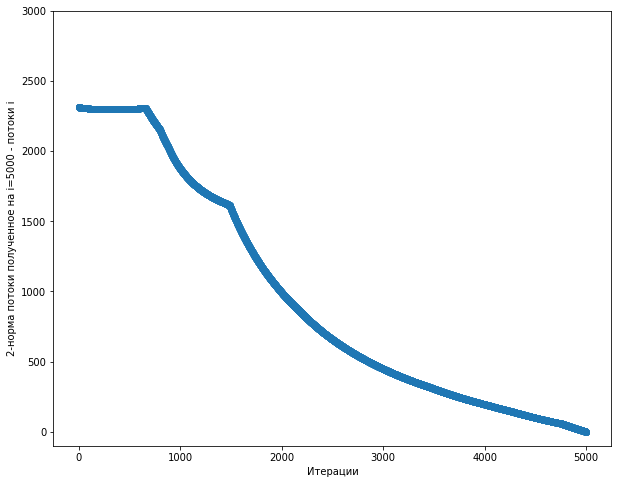

In [24]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(np.arange(len(result['flows_diff'])), result['flows_diff'])
plt.ylabel('2-норма потоки полученное на i=5000 - потоки i')
plt.xlabel('Итерации')
plt.ylim(-100.0, 3000.0)
plt.show()
fig.savefig('KEV_res/Flows_weight - Flows_weight_prev, 5000 iter 2.png')

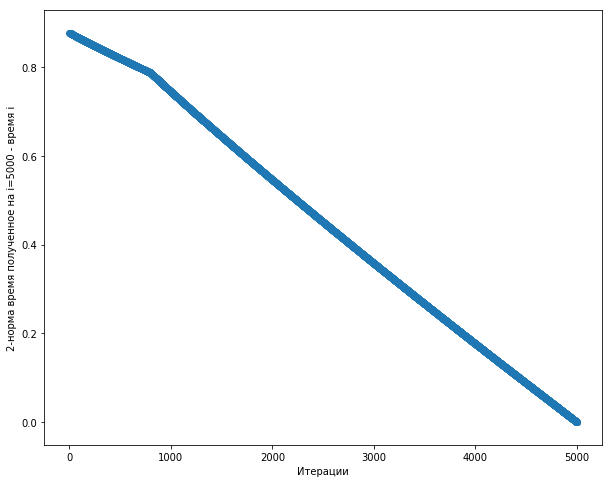

In [25]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.arange(len(result['times_diff'])), result['times_diff'])
plt.ylabel('2-норма время полученное на i=10000 - время i')
plt.xlabel('Итерации')
# plt.ylim(0.8, 0.9)
# plt.xlim(600, 800)
plt.show()
fig.savefig('KEV_res/T - T_prev, 5000 iter 2.png')

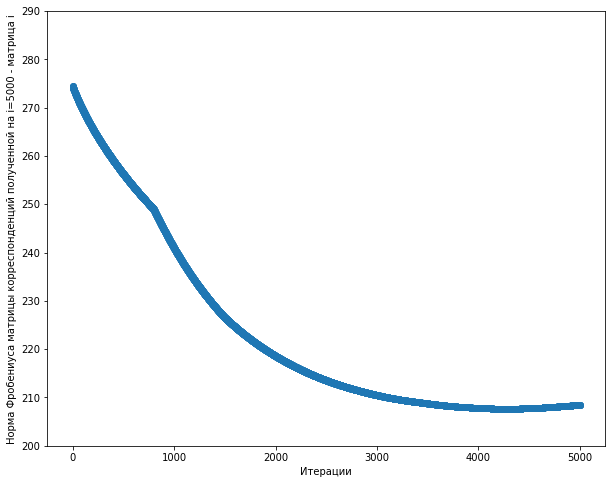

In [30]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(np.arange(len(result['corr_diff'])), result['corr_diff'])
plt.ylabel('Норма Фробениуса матрицы корреспонденций полученной на i=5000 - матрица i')
plt.xlabel('Итерации')
plt.ylim(200.0, 290.0)
plt.show()
fig.savefig('KEV_res/Rec_matrix - Rec_matrix_prev, 5000 iter 2.png')

In [31]:
flows_5000 = result['flows']
times_5000 = result['times']
corr_5000  = result['corr']
np.set_printoptions(precision=None, suppress=None) 

np.savetxt('KEV_res//flows_5000_new.txt', flows_5000, delimiter=',')
np.savetxt('KEV_res//times_5000_new.txt', times_5000, delimiter=',')
np.savetxt('KEV_res//corr_5000_new.txt',  corr_5000)

#### n = 10000 test

In [70]:
n = 10000

corr_10  = np.loadtxt('KEV_res//arrays//corrs//' + str(n) + '.txt')
flows_10 = np.loadtxt('KEV_res//arrays//flows//' + str(n) + '.txt')
times_10 = np.loadtxt('KEV_res//arrays/times//'  + str(n) + '.txt')

In [71]:
flows_w_d = []
rec_d = []
t_d = []


for i in range(1, n):
    flows_weighted = np.loadtxt('KEV_res//arrays//flows//' + str(i) + '.txt')
    rec = np.loadtxt('KEV_res//arrays//corrs//' + str(i) + '.txt')
    t = np.loadtxt('KEV_res//arrays/times//' + str(i) + '.txt')
    
    flows_w_d.append(np.linalg.norm(flows_10 - flows_weighted))
    rec_d.append((np.linalg.norm(corr_10 - rec)))
    t_d.append(np.linalg.norm(times_10 - t))

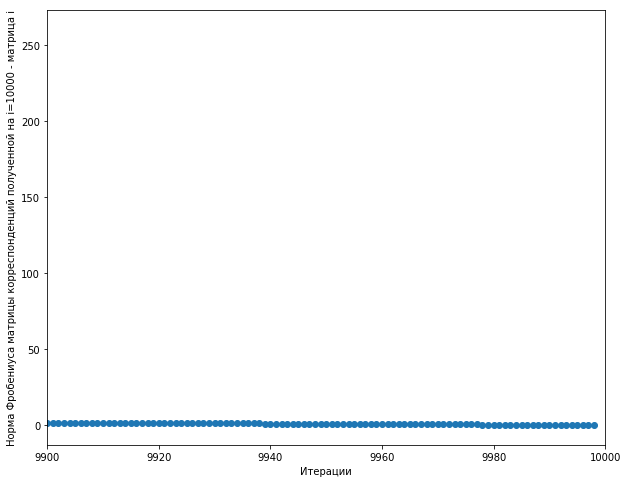

In [91]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(np.arange(n-1), rec_d)
plt.ylabel('Норма Фробениуса матрицы корреспонденций полученной на i=10000 - матрица i')
plt.xlabel('Итерации')
plt.xlim(9900.0, 10000.0)
plt.show()
fig.savefig('KEV_res/Rec_matrix - Rec_matrix_prev, 9900-10000 iter.png')